In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from DataLoader import HeartFailureDataset
import matplotlib.colors as colors
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from random import sample


load_data = HeartFailureDataset()
X = load_data.get_features()
y = load_data.get_targets()



Daten wurden geladen, jetzt bereiten wir unsere Daten für die SVM vor:
    - skalieren
    - in ein np.array umwandeln
    - die Werte der y-Variablen von {0,1} auf {-1,1} skalieren

In [28]:

from sklearn.preprocessing import StandardScaler

cols_to_scale = ['creatinine_phosphokinase', 'platelets', 'serum_sodium']

scaler = StandardScaler()
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

X = np.array(X)
y = np.array(y).reshape(-1)
y = np.where(y == 0, -1, 1)


Als nächstes schreiben wir eine Klasse für das Trainning einer SVM mit Gradientenabstieg. Wir verwenden ein Soft Margin SVM mit Hinge Loss:
$$
\mathcal{L}(w, b) = \frac{1}{2} \|w\|^2 + C \cdot \frac{1}{n} \sum_{i=1}^n \max\left(0, 1 - y_i \cdot (x_i^\top w + b)\right)
$$

In [3]:
def gradient_descent(f, f_gradient, f_hessian, x_0, step_size, max_iter=1000, eps=1e-7):
    d = x_0.shape[0]
    thetas = np.zeros((max_iter,d))
    thetas[0] = x_0

    for i in range(1, max_iter):
        grad = np.squeeze(f_gradient(thetas[i-1]))
        step = step_size(i-1) if callable(step_size) else step_size
        theta_next = thetas[i-1] - step * grad
        thetas[i] = theta_next
        if np.sum(grad**2) < eps*eps:
            break
    return thetas

def hinge_loss(t):
    return np.maximum(0, 1 - t)

def hinge_gradient(t):
    return (t < 1).astype(float) * -1

def svm_loss(w, b, C, x, y):
    loss = 0.5*np.sum(w**2, axis=0) + C/x.shape[0] * np.sum(hinge_loss(y*(np.matmul(x, w) + b)), axis=0)
    print(loss)
    return loss

def svm_gradient(w, b, C, x, y):
    n, d = x.shape
    if w.ndim == 1:
        m = 1
    else:
        m = w.shape[1]
        if isinstance(b, np.ndarray):
            b = b.reshape(1, m) 
    w = w.reshape(d, m)
    y = y.reshape(n, 1)
    w_bar = w + C/n * np.einsum('nm,nd->dm', hinge_gradient(y*(np.matmul(x, w) + b)), y*x)
    b_bar = C/n * np.sum(hinge_gradient(y*(np.matmul(x, w) + b))*y, axis=0, keepdims=True)
    return np.concatenate([w_bar, b_bar], axis=0).squeeze()



class SVM_GD(BaseEstimator, ClassifierMixin):
    def __init__(self, bias=True, C=1, step_size=0.00001, max_iter=1000):
        super(SVM_GD, self).__init__()
        
        self.bias = bias
        self.C = C
        self.step_size = step_size
        self.max_iter = max_iter
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_features = X.shape[1]

        # Initialisiere Startpunkt: w + b zusammen
        w_0 = np.zeros(n_features + 1)

        # Definiere Loss- und Gradientenfunktionen für Optimierung
        f = lambda w: svm_loss(w[:-1], w[-1], self.C, X, y)
        f_grad = lambda w: svm_gradient(w[:-1], w[-1], self.C, X, y)

        # Starte Gradientenabstieg
        trace = gradient_descent(f, f_grad, None, w_0, step_size=self.step_size, max_iter=self.max_iter)

        # Gewichte und Bias extrahieren aus letztem Punkt der Optimierung
        self.w = trace[-1, :-1]
        self.b = trace[-1, -1] if self.bias else 0
        #print(svm_loss(self.w, self.b, self.C,X,y))
        return trace
        
    def predict(self, X):
        if self.w is None or self.b is None:
            raise ValueError('Predict can only be called after supplying training data with fit first!')
        return np.sign(np.matmul(X, self.w) + self.b)
    
    


Wir schauen jetzt verschiedene Regularisierungen an. Dafür verändern wir die Konstante C in der Lossfunktion:
    - Je größer C gewählt wird, desto kleiner die Regularisierung

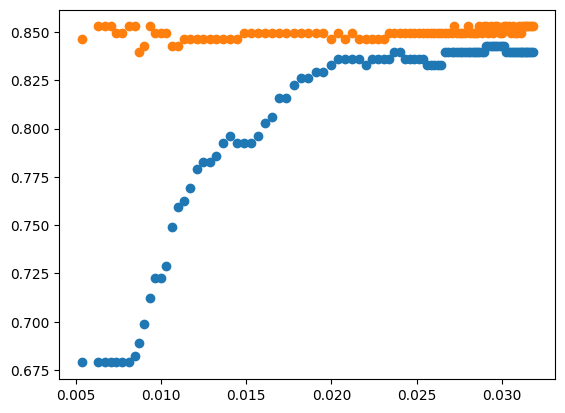

In [ ]:
    
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

accuracy_scores = []
accuracy_scores_scikit = [] 
norms = []
Css = np.arange(0.01, 1, 0.01)
for Cs in Css:
    SVM_model = SVM_GD(C = Cs)
    SVM_model.fit(X,y)
    norms.append(np.linalg.norm(SVM_model.w))
    y_pred = SVM_model.predict(X)
    acc = accuracy_score(y, y_pred)
    accuracy_scores.append(acc)
    #print(f"Training Accuracy: {acc:.2f}")
    
    svm_model = SVC(kernel='linear', C=Cs)
    svm_model.fit(X, y)
    y_pred = svm_model.predict(X)
    acc = accuracy_score(y, y_pred)
    accuracy_scores_scikit.append(acc)
plt.scatter(norms, accuracy_scores)
plt.scatter(norms, accuracy_scores_scikit)

C=1e-20: Accuracy=0.5000
C=3.8881551803081015e-20: Accuracy=0.5000
C=1.51177507061566e-19: Accuracy=0.5000
C=5.878016072274924e-19: Accuracy=0.5000
C=2.2854638641349837e-18: Accuracy=0.5000
C=8.886238162743408e-18: Accuracy=0.5835
C=3.4551072945922325e-17: Accuracy=0.8870
C=1.3433993325988988e-16: Accuracy=0.9110
C=5.223345074266854e-16: Accuracy=0.8826
C=2.0309176209047307e-15: Accuracy=0.8849
C=7.896522868499733e-15: Accuracy=0.8827
C=3.0702906297578495e-14: Accuracy=0.8824
C=1.1937766417144357e-13: Accuracy=0.8847
C=4.641588833612791e-13: Accuracy=0.8865
C=1.8047217668271739e-12: Accuracy=0.8865
C=7.017038286703837e-12: Accuracy=0.8860
C=2.7283333764867695e-11: Accuracy=0.8860
C=1.0608183551394483e-10: Accuracy=0.8860
C=4.124626382901348e-10: Accuracy=0.8860
C=1.6037187437513343e-09: Accuracy=0.8860
C=6.235507341273925e-09: Accuracy=0.8860
C=2.424462017082331e-08: Accuracy=0.8860
C=9.426684551178854e-08: Accuracy=0.8860
C=3.665241237079626e-07: Accuracy=0.8860
C=1.4251026703029963e-

<function matplotlib.pyplot.show(close=None, block=None)>

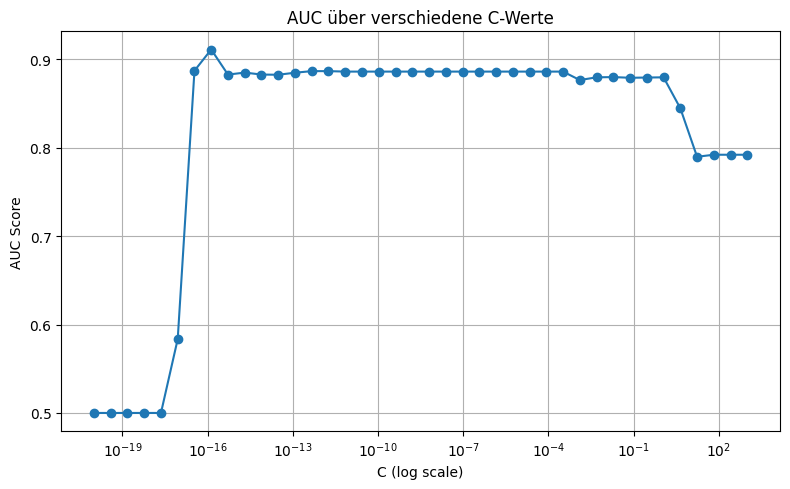

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np


import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from DataLoader import HeartFailureDataset
import matplotlib.colors as colors
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from random import sample


load_data = HeartFailureDataset()
X = load_data.get_features()
y = load_data.get_targets()
X = np.array(X)
y = np.array(y).reshape(-1)
scaler = StandardScaler()
scaler.fit(X)          # Mittelwert und Standardabweichung berechnen
X = scaler.transform(X)
y = y.reshape(-1)
C_values = np.logspace(-20, 3, 40)
scores = []

#X_scaled = StandardScaler().fit_transform(X)

for C in C_values:
    clf = SVC(C=C, max_iter=10000, kernel = "rbf")
    score = cross_val_score(clf, X, y, cv=5, scoring="roc_auc").mean()
    scores.append(score)

best_C = C_values[np.argmax(scores)]
print("Bestes C:", best_C)

import matplotlib.pyplot as plt

# Visualisierung
plt.figure(figsize=(8, 5))
plt.plot(C_values, scores, marker='o', linestyle='-')
plt.xscale('log')  # C ist besser logarithmisch darstellbar
plt.xlabel('C (log scale)')
plt.ylabel('AUC Score')
plt.title('AUC über verschiedene C-Werte')
plt.grid(True)
plt.tight_layout()
plt.show